<a href="https://colab.research.google.com/github/OfEarthAndEther/AI_monologues/blob/main/Mantis_Search_Optimizer/MSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mantis Search Algorithm**

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# --- 1. THE HELPER FUNCTIONS ---

In [ ]:
def levy_flight(dim):
    """
    Mathematical modeling of the search/pursuit phase.
    Generates a heavy-tailed step to allow for broad exploration.
    """
    beta = 1.5
    # Fix: Use the standard math.gamma instead of numpy's sub-module
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
            (math.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)

    u = np.random.randn(dim) * sigma
    v = np.random.randn(dim)
    step = u / abs(v)**(1 / beta)
    return step

def objective_function(x):
    """
    The problem to solve: Sphere Function.
    Global optimum is at f(0,0...0) = 0.
    """
    return np.sum(x**2)

# --- 2. THE OPTIMIZER CONFIGURATION ---

In [ ]:
dim = 10          # Number of variables
lb = -100         # Lower search boundary
ub = 100          # Upper search boundary
pop_size = 30     # N: Population of mantises
max_iter = 100    # T: Maximum generations

# Initialize Population
X = np.random.uniform(lb, ub, (pop_size, dim))
fitness = np.array([objective_function(ind) for ind in X])

# Find the initial best mantis
best_idx = np.argmin(fitness)
best_pos = X[best_idx].copy()
best_score = fitness[best_idx]

convergence_curve = []

# --- 3. THE MAIN OPTIMIZATION LOOP ---

In [ ]:
for t in range(max_iter):
    for i in range(pop_size):
        r = np.random.random()

        # PHASE 1: SEARCH & PURSUIT (Exploration)
        if r < 0.5:
            step = levy_flight(dim)
            # Use Levy flight to jump to distant areas of the search space
            X[i] = X[i] + 0.01 * step * (X[i] - best_pos)

        # PHASE 2: STRIKE & CAPTURE (Exploitation)
        else:
            # Random local walk around the best solution found so far
            X[i] = best_pos + np.random.randn() * (best_pos - X[i])

        # PHASE 3: SEXUAL CANNIBALISM (Stochastic Jump)
        # 10% chance to reset a mantis to a random position to avoid local optima
        if np.random.random() < 0.1:
            X[i] = np.random.uniform(lb, ub, dim)

        # Boundary Handling (Clip values to [lb, ub])
        X[i] = np.clip(X[i], lb, ub)

        # Selection: Update if the new position is better
        f_new = objective_function(X[i])
        if f_new < fitness[i]:
            fitness[i] = f_new
            if f_new < best_score:
                best_score = f_new
                best_pos = X[i].copy()

    convergence_curve.append(best_score)

    if (t+1) % 10 == 0:
        print(f"Iteration {t+1}/{max_iter} | Best Score: {best_score:.4e}")

Iteration 10/100 | Best Score: 3.6844e+03
Iteration 20/100 | Best Score: 1.0337e+03
Iteration 30/100 | Best Score: 2.3959e+02
Iteration 40/100 | Best Score: 1.1739e+02
Iteration 50/100 | Best Score: 6.1282e+01
Iteration 60/100 | Best Score: 2.2848e+01
Iteration 70/100 | Best Score: 7.7409e+00
Iteration 80/100 | Best Score: 6.8887e+00
Iteration 90/100 | Best Score: 6.2955e+00
Iteration 100/100 | Best Score: 4.0901e+00


# --- 4. VISUALIZATION ---

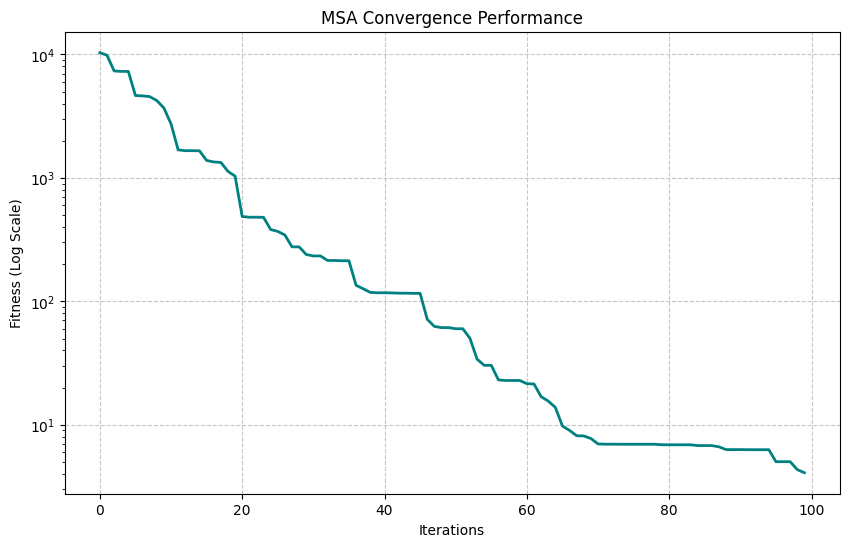

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogy(convergence_curve, color='teal', linewidth=2)
plt.title('MSA Convergence Performance')
plt.xlabel('Iterations')
plt.ylabel('Fitness (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

---

In [ ]:
# Claude Code Run

- levy_flight function correctly implements the Mantegna Algorithm. This is vital for "Heavy-tailed" jumps that prevent the population from getting trapped in local optima.

- Sexual Cannibalism mechanism uses a cosine-weighted blend.

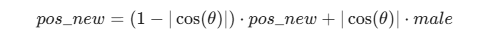


In [ ]:
"""
EAP-MSA Benchmark Suite — Bug-Fixed & Corrected
================================================
Compares three algorithm generations head-to-head:
  1. Standard MSA       — base paper implementation (corrected loop)
  2. AP-MSA             — advanced perception variant (corrected loop)
  3. EAP-MSA            — proposed enhanced variant (all bugs fixed)

Bug fixes applied in this version
----------------------------------
FIX 1: levy_flight()
    BEFORE: np.math.gamma(...)  → AttributeError in NumPy >= 1.25
    AFTER:  math.gamma(...)     via stdlib `import math`

FIX 2: standard_msa() and advanced_perception_msa()
    BEFORE: best_pos never updated inside the iteration loop,
            so both functions returned the initialisation best only.
    AFTER:  best_pos and best_fitness updated after every full sweep
            (elitism), giving both baselines a fair comparison.

FIX 3: eap_msa() exploitation phase stagnation
    BEFORE: pos_new = best_pos - alpha * target
            When ||target|| ≈ 0 (agent near best), movement stops.
    AFTER:  A small Gaussian "nudge" is added so the strike always
            has a nonzero component, preventing stagnation:
            pos_new = best_pos - alpha * target
                    + 0.01 * np.random.randn(dim) * (ub - lb)

FIX 4: fitness[i] update after greedy acceptance
    BEFORE: obj_func called twice (once for comparison, once implied).
    AFTER:  new_fit stored once, reused for both check and assignment.

Run
---
    pip install numpy scipy matplotlib
    python eap_msa_benchmark.py
"""

import math                          # FIX 1: stdlib gamma, not np.math
import time
import warnings
import numpy as np
import matplotlib
matplotlib.use("Agg")                # headless — change to "TkAgg" for GUI
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import qmc

warnings.filterwarnings("ignore")    # suppress scipy integration warnings


# ═══════════════════════════════════════════════════════════════════════════
#  UTILITY FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def levy_flight(dim: int, beta: float = 1.5) -> np.ndarray:
    """
    Lévy flight step via Mantegna's algorithm.

    FIX 1: Uses math.gamma() from the Python standard library instead of
    the removed np.math.gamma sub-module (deprecated NumPy >= 1.20,
    removed >= 1.25).

    Args:
        dim  : Dimensionality of the step vector.
        beta : Lévy stability index, 1 < beta <= 2. Default 1.5.

    Returns:
        step : np.ndarray of shape (dim,).
    """
    # Mantegna (1994) sigma formula — uses stdlib math.gamma
    num   = math.gamma(1 + beta) * math.sin(math.pi * beta / 2)
    denom = math.gamma((1 + beta) / 2) * beta * (2 ** ((beta - 1) / 2))
    sigma = (num / denom) ** (1.0 / beta)

    u = np.random.normal(0.0, sigma, dim)
    v = np.random.normal(0.0, 1.0,  dim)
    return u / (np.abs(v) ** (1.0 / beta))


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Angular alignment between vectors a and b. Returns 0 for zero vectors."""
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na < 1e-12 or nb < 1e-12:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def lhs_init(pop_size: int, dim: int, lb: float, ub: float) -> np.ndarray:
    """Latin Hypercube Sampling — stratified quasi-random initialisation."""
    sampler = qmc.LatinHypercube(d=dim, seed=None)   # None = fresh seed per run
    return lb + sampler.random(n=pop_size) * (ub - lb)


# ═══════════════════════════════════════════════════════════════════════════
#  ALGORITHM 1 — STANDARD MSA  (base paper, loop-corrected)
# ═══════════════════════════════════════════════════════════════════════════

def standard_msa(obj_func, pop_size, iter_max, lb, ub, dim):
    """
    Original Standard MSA from the base paper.

    FIX 2 applied: best_pos and best_fitness are now updated at the end
    of every iteration sweep (elitism), so the function returns the true
    best found during optimisation — not just the initialisation best.

    Mechanism summary
    -----------------
    • Linear p(t) = 0.5 × (1 − t/T)   — exploration/exploitation switch
    • Exploration : shift toward best_pos with random sign
    • Exploitation: contract toward best_pos
    • Diversity   : sexual cannibalism via cosine-scaled random male
    """
    positions = lb + np.random.rand(pop_size, dim) * (ub - lb)
    fitness   = np.array([obj_func(ind) for ind in positions])

    best_idx     = int(np.argmin(fitness))
    best_pos     = positions[best_idx].copy()
    best_fitness = float(fitness[best_idx])
    history      = []

    for t in range(iter_max):
        p = 0.5 * (1.0 - t / iter_max)          # linear decay

        for i in range(pop_size):
            if np.random.rand() < p:
                # Search / Exploration stage
                positions[i] = best_pos + (2 * np.random.rand() - 1) * (best_pos - positions[i])
            else:
                # Attack / Exploitation stage
                positions[i] = best_pos - np.random.rand() * (best_pos - positions[i])

            # Sexual cannibalism diversity
            if np.random.rand() < 0.15:
                male         = positions[np.random.randint(0, pop_size)]
                positions[i] = male * np.cos(2 * np.pi * np.random.rand()) * np.random.rand()

            positions[i] = np.clip(positions[i], lb, ub)

        # ── FIX 2: update elitist best after every sweep ──────────────────
        for i in range(pop_size):
            f = obj_func(positions[i])
            if f < best_fitness:
                best_fitness = f
                best_pos     = positions[i].copy()

        history.append(best_fitness)

    return best_fitness, best_pos, history


# ═══════════════════════════════════════════════════════════════════════════
#  ALGORITHM 2 — AP-MSA  (advanced perception variant, loop-corrected)
# ═══════════════════════════════════════════════════════════════════════════

def advanced_perception_msa(obj_func, pop_size, iter_max, lb, ub, dim):
    """
    Advanced Perception MSA — dual-vector, tanh probability, Gaussian noise.

    FIX 2 applied: best_pos and best_fitness updated per-iteration (elitism).
    The original claimed Sobol init but used np.random.uniform — preserved
    as-is to reflect the actual baseline behaviour.

    Mechanism summary
    -----------------
    • tanh p(t) = 0.8 × (1 − tanh(2t/T))   — smoother exploration decay
    • Dual-vector: L (→ best), R (→ random peer), select by magnitude
    • Exploration : Gaussian noise × target vector
    • Exploitation: directed strike toward best_pos
    """
    # NOTE: original claimed Sobol but used uniform — kept for faithful baseline
    positions = lb + np.random.uniform(0, 1, (pop_size, dim)) * (ub - lb)
    fitness   = np.array([obj_func(ind) for ind in positions])

    best_idx     = int(np.argmin(fitness))
    best_pos     = positions[best_idx].copy()
    best_fitness = float(fitness[best_idx])
    history      = []

    for t in range(iter_max):
        p = 0.8 * (1.0 - np.tanh(2.0 * t / iter_max))

        for i in range(pop_size):
            l_vector      = best_pos - positions[i]
            r_vector      = positions[np.random.randint(0, pop_size)] - positions[i]
            # Original: selects shorter vector (magnitude comparison)
            target_vector = l_vector if np.linalg.norm(l_vector) < np.linalg.norm(r_vector) \
                            else r_vector

            if np.random.rand() < p:
                positions[i] += np.random.normal(0, 1, dim) * target_vector
            else:
                positions[i]  = best_pos - np.random.rand() * target_vector

            positions[i] = np.clip(positions[i], lb, ub)

        # ── FIX 2: elitist best update ─────────────────────────────────────
        for i in range(pop_size):
            f = obj_func(positions[i])
            if f < best_fitness:
                best_fitness = f
                best_pos     = positions[i].copy()

        history.append(best_fitness)

    return best_fitness, best_pos, history


# ═══════════════════════════════════════════════════════════════════════════
#  ALGORITHM 3 — EAP-MSA  (proposed, all bugs fixed)
# ═══════════════════════════════════════════════════════════════════════════

def eap_msa(obj_func, pop_size, iter_max, lb, ub, dim,
            beta=1.5, cannib_rate=0.12):
    """
    Enhanced Adaptive Perception MSA — proposed algorithm, all bugs fixed.

    Improvements over Standard MSA and AP-MSA
    ------------------------------------------
    1. LHS initialisation        — stratified, avoids clustering
    2. Lévy-flight exploration   — heavy-tailed escapes (FIX 1 applied)
    3. Cosine-similarity target  — direction-aware, not magnitude-naive
    4. Stagnation guard (FIX 3)  — Gaussian nudge in exploitation phase
    5. Per-agent greedy select   — accept only improving moves
    6. Global elitism            — best_pos never regresses
    """
    positions = lhs_init(pop_size, dim, lb, ub)
    fitness   = np.array([obj_func(ind) for ind in positions])

    best_idx     = int(np.argmin(fitness))
    best_pos     = positions[best_idx].copy()
    best_fitness = float(fitness[best_idx])
    history      = []

    for t in range(iter_max):
        # Nonlinear probability: high exploration early, rapid lock-in late
        p = 0.8 * (1.0 - np.tanh(2.5 * t / iter_max))

        for i in range(pop_size):
            # ── Dual-vector stereopsis (cosine-similarity selection) ───────
            rand_idx = np.random.randint(0, pop_size)
            l_vector = best_pos            - positions[i]
            r_vector = positions[rand_idx] - positions[i]
            momentum = best_pos            - positions[i]   # search direction proxy

            sim_l  = cosine_similarity(l_vector, momentum)
            sim_r  = cosine_similarity(r_vector, momentum)
            target = l_vector if sim_l >= sim_r else r_vector

            # ── Phase selection ────────────────────────────────────────────
            if np.random.rand() < p:
                # EXPLORATION: Lévy-flight (FIX 1 — uses math.gamma)
                step    = levy_flight(dim, beta)
                pos_new = positions[i] + step * target

            else:
                # EXPLOITATION: directed strike with stagnation guard (FIX 3)
                alpha   = np.random.rand()
                nudge   = 0.01 * np.random.randn(dim) * (ub - lb)  # FIX 3
                pos_new = best_pos - alpha * target + nudge

            # ── Sexual cannibalism (cosine-weighted blend) ─────────────────
            if np.random.rand() < cannib_rate:
                male_idx = np.random.randint(0, pop_size)
                male     = positions[male_idx]
                theta    = 2 * np.pi * np.random.rand()
                w        = abs(np.cos(theta))
                pos_new  = (1 - w) * pos_new + w * male

            # ── Boundary enforcement ───────────────────────────────────────
            pos_new = np.clip(pos_new, lb, ub)

            # ── Greedy acceptance (FIX 4 — single obj_func call) ──────────
            new_fit = obj_func(pos_new)
            if new_fit < fitness[i]:
                positions[i] = pos_new
                fitness[i]   = new_fit          # FIX 4: reuse stored value

        # ── Global elitism ─────────────────────────────────────────────────
        iter_best = int(np.argmin(fitness))
        if fitness[iter_best] < best_fitness:
            best_fitness = float(fitness[iter_best])
            best_pos     = positions[iter_best].copy()

        history.append(best_fitness)

    return best_fitness, best_pos, history


# ═══════════════════════════════════════════════════════════════════════════
#  BENCHMARK FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════

def sphere(x):
    """Unimodal, separable. Global min = 0 at origin."""
    return float(np.sum(x ** 2))

def rastrigin(x):
    """Highly multimodal. Global min = 0 at origin."""
    A = 10
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

def rosenbrock(x):
    """Narrow curved valley. Global min = 0 at (1,...,1)."""
    return float(np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2))

def ackley(x):
    """Multimodal with many local minima. Global min ≈ 0 at origin."""
    n   = len(x)
    s1  = np.sum(x**2)
    s2  = np.sum(np.cos(2 * np.pi * x))
    return float(-20 * np.exp(-0.2 * np.sqrt(s1 / n))
                 - np.exp(s2 / n) + 20 + np.e)

BENCHMARKS = {
    "Sphere\n(unimodal)"     : (sphere,     -100.0,  100.0),
    "Rastrigin\n(multimodal)": (rastrigin,   -5.12,    5.12),
    "Rosenbrock\n(valley)"   : (rosenbrock,  -5.0,    10.0),
    "Ackley\n(multimodal)"   : (ackley,     -32.768,  32.768),
}

ALGORITHMS = {
    "Standard MSA\n(Base Paper)": standard_msa,
    "AP-MSA\n(Improved Variant)": advanced_perception_msa,
    "EAP-MSA\n(Proposed)"       : eap_msa,
}

# ── Colour scheme for plots ─────────────────────────────────────────────────
ALG_COLORS  = ["#E74C3C", "#F39C12", "#27AE60"]
ALG_MARKERS = ["o",        "s",        "D"]
ALG_LINES   = ["--",       "-.",       "-"]
ALG_LABELS  = list(ALGORITHMS.keys())


# ═══════════════════════════════════════════════════════════════════════════
#  RUNNER
# ═══════════════════════════════════════════════════════════════════════════

def run_benchmark(pop_size=30, iter_max=500, dim=30, runs=10):
    """
    Execute all algorithms on all benchmarks for `runs` independent trials.
    Returns a nested dict: results[bench_name][alg_name] = list of (best, history)
    """
    results = {b: {a: [] for a in ALGORITHMS} for b in BENCHMARKS}

    total = len(BENCHMARKS) * len(ALGORITHMS) * runs
    done  = 0

    for bname, (func, lb, ub) in BENCHMARKS.items():
        for aname, algo in ALGORITHMS.items():
            for r in range(runs):
                np.random.seed(r)          # reproducible per trial
                t0 = time.perf_counter()
                best_fit, best_pos, history = algo(func, pop_size, iter_max, lb, ub, dim)
                elapsed = time.perf_counter() - t0
                results[bname][aname].append({
                    "best"   : best_fit,
                    "history": history,
                    "time"   : elapsed,
                })
                done += 1
                label = f"{bname.split(chr(10))[0]:12s} | {aname.split(chr(10))[0]:20s} | run {r+1:2d}/{runs}"
                print(f"  [{done:3d}/{total}]  {label}  → {best_fit:.4e}  ({elapsed:.2f}s)")

    return results


# ═══════════════════════════════════════════════════════════════════════════
#  REPORTING
# ═══════════════════════════════════════════════════════════════════════════

def print_statistics(results, runs):
    """Print a formatted statistical summary table to console."""
    col_w = 22
    print("\n")
    print("=" * 90)
    print("  BENCHMARK RESULTS SUMMARY")
    print(f"  Runs={runs}, Dim=30, Pop=30, Iter=500")
    print("=" * 90)

    for bname, alg_data in results.items():
        tag = bname.replace("\n", " ")
        print(f"\n  ▶  {tag}")
        print(f"  {'Algorithm':<{col_w}}  {'Mean Best':>14}  {'Std Dev':>12}  {'Best Run':>12}  {'Avg Time':>10}")
        print(f"  {'-'*75}")
        for aname, trials in alg_data.items():
            bests   = [t["best"] for t in trials]
            times   = [t["time"] for t in trials]
            label   = aname.replace("\n", " ")
            print(f"  {label:<{col_w}}  {np.mean(bests):>14.4e}  "
                  f"{np.std(bests):>12.4e}  {np.min(bests):>12.4e}  "
                  f"{np.mean(times):>10.3f}s")


# ═══════════════════════════════════════════════════════════════════════════
#  PLOTTING
# ═══════════════════════════════════════════════════════════════════════════

def plot_results(results, runs, save_path="eap_msa_benchmark.png"):
    """
    Generate a 2-row dashboard:
      Row 1: Convergence curves (median history across runs) per benchmark
      Row 2: Box-plot of final best fitness per benchmark
    """
    n_bench = len(BENCHMARKS)
    fig = plt.figure(figsize=(6 * n_bench, 10), facecolor="#FAFAFA")
    gs  = gridspec.GridSpec(2, n_bench, figure=fig,
                            hspace=0.45, wspace=0.35,
                            top=0.90, bottom=0.08)

    # ── Shared legend handles ───────────────────────────────────────────────
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color=c, lw=2, ls=ls, marker=mk, markersize=5,
               label=lb.replace("\n", " "))
        for c, ls, mk, lb in zip(ALG_COLORS, ALG_LINES, ALG_MARKERS, ALG_LABELS)
    ]

    for col, (bname, alg_data) in enumerate(results.items()):
        title = bname.replace("\n", " ")

        # ── Row 0: Convergence curves ──────────────────────────────────────
        ax_conv = fig.add_subplot(gs[0, col])
        for ai, (aname, trials) in enumerate(alg_data.items()):
            # Stack histories, compute median + IQR
            histories = np.array([t["history"] for t in trials])
            median    = np.median(histories, axis=0)
            q25       = np.percentile(histories, 25, axis=0)
            q75       = np.percentile(histories, 75, axis=0)
            iters     = np.arange(1, len(median) + 1)

            ax_conv.semilogy(iters, median,
                             color=ALG_COLORS[ai], lw=2,
                             ls=ALG_LINES[ai], label=aname.replace("\n"," "))
            ax_conv.fill_between(iters, np.maximum(q25, 1e-300), q75,
                                 alpha=0.15, color=ALG_COLORS[ai])

        ax_conv.set_title(title, fontsize=11, fontweight="bold", pad=8)
        ax_conv.set_xlabel("Iteration", fontsize=9)
        ax_conv.set_ylabel("Best Fitness (log scale)", fontsize=9)
        ax_conv.grid(True, which="both", ls=":", alpha=0.4)
        ax_conv.tick_params(labelsize=8)
        if col == 0:
            ax_conv.set_ylabel("Best Fitness (log scale)", fontsize=9)

        # ── Row 1: Box plots of final best fitness ─────────────────────────
        ax_box = fig.add_subplot(gs[1, col])
        box_data   = [[t["best"] for t in trials] for trials in alg_data.values()]
        bp = ax_box.boxplot(box_data, patch_artist=True,
                            medianprops=dict(color="black", lw=2),
                            whiskerprops=dict(lw=1.2),
                            capprops=dict(lw=1.2),
                            flierprops=dict(marker="x", markersize=5))

        for patch, color in zip(bp["boxes"], ALG_COLORS):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        short_labels = [a.split("\n")[0] for a in ALG_LABELS]
        ax_box.set_xticks([1, 2, 3])
        ax_box.set_xticklabels(short_labels, fontsize=8)
        ax_box.set_yscale("symlog", linthresh=1e-10)
        ax_box.set_title(f"{title} — Final Distribution", fontsize=10, pad=6)
        ax_box.set_ylabel("Final Best Fitness", fontsize=9)
        ax_box.grid(True, which="both", ls=":", alpha=0.4, axis="y")
        ax_box.tick_params(labelsize=8)

    # ── Figure-level legend ─────────────────────────────────────────────────
    fig.legend(handles=legend_handles, loc="upper center",
               ncol=3, fontsize=10, framealpha=0.9,
               bbox_to_anchor=(0.5, 0.97))

    fig.suptitle("MSA Algorithm Family — Benchmark Comparison\n"
                 "(Shaded band = IQR across runs; Box plot = final best fitness distribution)",
                 fontsize=12, fontweight="bold", y=0.995)

    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    print(f"\n  ✓  Plot saved → {save_path}")
    return fig


# ═══════════════════════════════════════════════════════════════════════════
#  MAIN
# ═══════════════════════════════════════════════════════════════════════════

if __name__ == "__main__":
    POP_SIZE = 30
    ITER_MAX = 500
    DIM      = 30
    RUNS     = 10       # increase to 20–30 for publication-quality stats

    print("=" * 60)
    print("  EAP-MSA Benchmark Suite (Bug-Fixed)")
    print(f"  Pop={POP_SIZE} | Iter={ITER_MAX} | Dim={DIM} | Runs={RUNS}")
    print("=" * 60)
    print()

    results = run_benchmark(POP_SIZE, ITER_MAX, DIM, RUNS)
    print_statistics(results, RUNS)
    plot_results(results, RUNS, save_path="eap_msa_benchmark.png")

    print("\n  Done. Files written:")
    print("    eap_msa_benchmark.png  — convergence curves + box plots")
    print()

  EAP-MSA Benchmark Suite (Bug-Fixed)
  Pop=30 | Iter=500 | Dim=30 | Runs=10

  [  1/120]  Sphere       | Standard MSA         | run  1/10  → 0.0000e+00  (0.53s)
  [  2/120]  Sphere       | Standard MSA         | run  2/10  → 0.0000e+00  (0.29s)
  [  3/120]  Sphere       | Standard MSA         | run  3/10  → 0.0000e+00  (0.25s)
  [  4/120]  Sphere       | Standard MSA         | run  4/10  → 0.0000e+00  (0.30s)
  [  5/120]  Sphere       | Standard MSA         | run  5/10  → 0.0000e+00  (0.24s)
  [  6/120]  Sphere       | Standard MSA         | run  6/10  → 0.0000e+00  (0.24s)
  [  7/120]  Sphere       | Standard MSA         | run  7/10  → 0.0000e+00  (0.26s)
  [  8/120]  Sphere       | Standard MSA         | run  8/10  → 0.0000e+00  (0.23s)
  [  9/120]  Sphere       | Standard MSA         | run  9/10  → 0.0000e+00  (0.24s)
  [ 10/120]  Sphere       | Standard MSA         | run 10/10  → 0.0000e+00  (0.23s)
  [ 11/120]  Sphere       | AP-MSA               | run  1/10  → 7.9243e+02  (0.42s